# 🗺️ Análisis de Heterogeneidad en Predicción por Municipio

## Objetivo
Identificar si el modelo predice mejor en ciertos municipios que en otros, lo cual sugeriría:
- **Dinámicas diferentes** de violencia entre territorios
- Necesidad de **modelos segmentados** por tipo de municipio
- Clusters de municipios con **patrones predecibles vs. impredecibles**

## Metodología
1. Entrenar modelo base
2. Calcular métricas por municipio
3. Identificar municipios con mejor/peor performance
4. Caracterizar diferencias (tamaño, región, violencia histórica, etc.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    balanced_accuracy_score, precision_score, recall_score
)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline


from pathlib import Path  # For cross-platform file path handling
import yaml  # To read YAML configuration files

# Load directory paths from configuration file
with open('paths.yml', 'r') as file:
    paths = yaml.safe_load(file)  # Read and parse YAML file

# Create Path objects for each directory
raw = Path(paths['data']['raw'])  # Directory with raw data
temp = Path(paths['data']['temp'])  # Directory with temporary processed data
processed = Path(paths['data']['processed'])  # Directory with final processed data
model = Path(paths['outputs']['model'])

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Configuración y Carga de Datos

In [2]:
# CONFIGURACIÓN
DATA_PATH = processed/'db_no_jep.parquet'
RESULTS_DIR = "/Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous"

TARGET_COL = 'atypical_violence'
TIME_COL = 'quarter'
MUNICIPALITY_COL = 'mun_code'

COLS_TO_EXCLUDE = [
    'atypical_violence',
    'mun_code', 'quarter',
    'iacv', 'iacv_t', 'qty_iacv', 'qty_01', 'qty_02', 'qty_03', 'qty_04', 'qty_05',
    'population',
    '_merge'
]

TRAIN_PROP = 0.70
RANDOM_STATE = 42

# Umbral mínimo de observaciones por municipio para análisis confiable
MIN_OBS_PER_MUNICIPALITY = 10

print("✓ Configuración cargada")

✓ Configuración cargada


In [3]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)

# Extraer temporales
df['año'] = df[TIME_COL].astype(str).str[:4].astype(int)
df['trimestre'] = df[TIME_COL].astype(str).str[-1].astype(int)
df['periodo_num'] = df['año'] * 10 + df['trimestre']
df = df.sort_values(['periodo_num', MUNICIPALITY_COL]).reset_index(drop=True)

print(f"Dataset: {df.shape}")
print(f"Municipios únicos: {df[MUNICIPALITY_COL].nunique()}")
print(f"Periodos únicos: {df[TIME_COL].nunique()}")
print(f"Prevalencia global de {TARGET_COL}: {df[TARGET_COL].mean():.2%}")

Dataset: (76184, 70)
Municipios únicos: 1121
Periodos únicos: 68
Prevalencia global de atypical_violence: 18.73%


In [4]:
# Análisis de cobertura por municipio
mun_stats = df.groupby(MUNICIPALITY_COL).agg({
    TIME_COL: 'count',
    TARGET_COL: ['sum', 'mean']
}).reset_index()
mun_stats.columns = ['mun_code', 'n_obs', 'n_positives', 'prevalence']

print(f"\nEstadísticas por municipio:")
print(f"  Observaciones promedio: {mun_stats['n_obs'].mean():.1f}")
print(f"  Observaciones min: {mun_stats['n_obs'].min()}")
print(f"  Observaciones max: {mun_stats['n_obs'].max()}")
print(f"\nMunicipios con ≥ {MIN_OBS_PER_MUNICIPALITY} obs: {(mun_stats['n_obs'] >= MIN_OBS_PER_MUNICIPALITY).sum()}")
print(f"Municipios con eventos positivos: {(mun_stats['n_positives'] > 0).sum()}")

# Municipios con suficientes datos
mun_with_data = mun_stats[mun_stats['n_obs'] >= MIN_OBS_PER_MUNICIPALITY]['mun_code'].tolist()
print(f"\nMunicipios válidos para análisis: {len(mun_with_data)}")


Estadísticas por municipio:
  Observaciones promedio: 68.0
  Observaciones min: 56
  Observaciones max: 68

Municipios con ≥ 10 obs: 1121
Municipios con eventos positivos: 1110

Municipios válidos para análisis: 1121


## 2. Preparación de Datos para Modelado

In [5]:
# Splits temporales
periodos_unicos = sorted(df[TIME_COL].unique())
n_periodos = len(periodos_unicos)
train_end_idx = int(n_periodos * TRAIN_PROP)
val_end_idx = int(n_periodos * (TRAIN_PROP + 0.15))

train_periods = periodos_unicos[:train_end_idx]
val_periods = periodos_unicos[train_end_idx:val_end_idx]
test_periods = periodos_unicos[val_end_idx:]

train_mask = df[TIME_COL].isin(train_periods)
val_mask = df[TIME_COL].isin(val_periods)
test_mask = df[TIME_COL].isin(test_periods)

print(f"Splits temporales:")
print(f"  Train: {len(train_periods)} periodos | {train_mask.sum():,} obs")
print(f"  Val:   {len(val_periods)} periodos | {val_mask.sum():,} obs")
print(f"  Test:  {len(test_periods)} periodos | {test_mask.sum():,} obs")

Splits temporales:
  Train: 47 periodos | 52,643 obs
  Val:   10 periodos | 11,210 obs
  Test:  11 periodos | 12,331 obs


In [6]:
# Separar features y target
derived_cols = ['año', 'trimestre', 'periodo_num']
all_cols_to_exclude = list(set(COLS_TO_EXCLUDE + derived_cols))
cols_excluir_existentes = [col for col in all_cols_to_exclude if col in df.columns]

feature_cols = [col for col in df.columns if col not in cols_excluir_existentes]

X = df[feature_cols].copy()
y = df[TARGET_COL].copy()
mun_ids = df[MUNICIPALITY_COL].copy()  # Guardar IDs de municipio

X_train, y_train, mun_train = X[train_mask].copy(), y[train_mask].copy(), mun_ids[train_mask].copy()
X_val, y_val, mun_val = X[val_mask].copy(), y[val_mask].copy(), mun_ids[val_mask].copy()
X_test, y_test, mun_test = X[test_mask].copy(), y[test_mask].copy(), mun_ids[test_mask].copy()

print(f"\nFeatures: {len(feature_cols)}")
print(f"Municipios en test: {mun_test.nunique()}")


Features: 54
Municipios en test: 1121


In [7]:
# Imputación y estandarización
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Imputar
num_imputer = SimpleImputer(strategy='median')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = num_imputer.transform(X_val[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

# Estandarizar
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val), 
    columns=X_val.columns, 
    index=X_val.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print("✓ Datos preparados")

✓ Datos preparados


## 3. Entrenar Modelo Base

In [8]:
# Modelo simple para este análisis
model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    C=1.0,
    max_iter=2000,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Entrenando modelo base...")
# Entrenar con train+val
X_train_val = pd.concat([X_train_scaled, X_val_scaled])
y_train_val = pd.concat([y_train, y_val])

model.fit(X_train_val, y_train_val)
print("✓ Modelo entrenado")

# Predicciones en test
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = model.predict(X_test_scaled)

# Métricas globales
print(f"\nPerformance global en test:")
print(f"  AUPRC: {average_precision_score(y_test, y_test_proba):.4f}")
print(f"  AUROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"  F1: {f1_score(y_test, y_test_pred):.4f}")
print(f"  Balanced Acc: {balanced_accuracy_score(y_test, y_test_pred):.4f}")

Entrenando modelo base...
✓ Modelo entrenado

Performance global en test:
  AUPRC: 0.2852
  AUROC: 0.6327
  F1: 0.3832
  Balanced Acc: 0.6026


## 4. Calcular Métricas por Municipio

In [9]:
# Crear DataFrame con predicciones por municipio
test_results = pd.DataFrame({
    'mun_code': mun_test.values,
    'y_true': y_test.values,
    'y_pred': y_test_pred,
    'y_proba': y_test_proba
})

print(f"Observaciones en test: {len(test_results):,}")
print(f"Municipios únicos en test: {test_results['mun_code'].nunique()}")

Observaciones en test: 12,331
Municipios únicos en test: 1121


In [10]:
# Función para calcular métricas por municipio
def calculate_municipality_metrics(group):
    """
    Calcula métricas de performance para un municipio.
    Maneja casos edge (pocos datos, sin positivos, etc.)
    """
    y_true = group['y_true'].values
    y_pred = group['y_pred'].values
    y_proba = group['y_proba'].values
    
    n_obs = len(y_true)
    n_positives = y_true.sum()
    prevalence = y_true.mean()
    
    # Inicializar métricas
    metrics = {
        'n_obs': n_obs,
        'n_positives': int(n_positives),
        'prevalence': prevalence
    }
    
    # Si no hay suficientes observaciones o varianza
    if n_obs < MIN_OBS_PER_MUNICIPALITY:
        metrics.update({
            'auroc': np.nan,
            'auprc': np.nan,
            'f1': np.nan,
            'balanced_acc': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'status': 'insufficient_data'
        })
        return pd.Series(metrics)
    
    # Si solo una clase presente
    if len(np.unique(y_true)) < 2:
        metrics.update({
            'auroc': np.nan,
            'auprc': prevalence,  # Baseline AUPRC
            'f1': np.nan,
            'balanced_acc': np.nan,
            'precision': np.nan,
            'recall': np.nan,
            'status': 'no_variance'
        })
        return pd.Series(metrics)
    
    # Calcular métricas
    try:
        auroc = roc_auc_score(y_true, y_proba)
    except:
        auroc = np.nan
    
    try:
        auprc = average_precision_score(y_true, y_proba)
    except:
        auprc = np.nan
    
    try:
        f1 = f1_score(y_true, y_pred, zero_division=0)
    except:
        f1 = np.nan
    
    try:
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
    except:
        balanced_acc = np.nan
    
    try:
        precision = precision_score(y_true, y_pred, zero_division=0)
    except:
        precision = np.nan
    
    try:
        recall = recall_score(y_true, y_pred, zero_division=0)
    except:
        recall = np.nan
    
    metrics.update({
        'auroc': auroc,
        'auprc': auprc,
        'f1': f1,
        'balanced_acc': balanced_acc,
        'precision': precision,
        'recall': recall,
        'status': 'valid'
    })
    
    return pd.Series(metrics)

# Calcular por municipio
print("Calculando métricas por municipio...")
mun_performance = test_results.groupby('mun_code').apply(calculate_municipality_metrics).reset_index()

# Solo municipios válidos
mun_performance_valid = mun_performance[mun_performance['status'] == 'valid'].copy()

print(f"\nMunicipios válidos para análisis: {len(mun_performance_valid)}")
print(f"Municipios excluidos (datos insuficientes): {(mun_performance['status'] == 'insufficient_data').sum()}")
print(f"Municipios excluidos (sin varianza): {(mun_performance['status'] == 'no_variance').sum()}")

Calculando métricas por municipio...

Municipios válidos para análisis: 1031
Municipios excluidos (datos insuficientes): 0
Municipios excluidos (sin varianza): 90


## 5. Análisis de Heterogeneidad en Performance

In [11]:
# Estadísticas descriptivas
print("="*70)
print("ESTADÍSTICAS DE PERFORMANCE POR MUNICIPIO")
print("="*70)

for metric in ['auprc', 'auroc', 'f1', 'balanced_acc']:
    values = mun_performance_valid[metric].dropna()
    print(f"\n{metric.upper()}:")
    print(f"  Media:    {values.mean():.4f}")
    print(f"  Mediana:  {values.median():.4f}")
    print(f"  Std:      {values.std():.4f}")
    print(f"  Min:      {values.min():.4f}")
    print(f"  Max:      {values.max():.4f}")
    print(f"  P25:      {values.quantile(0.25):.4f}")
    print(f"  P75:      {values.quantile(0.75):.4f}")

ESTADÍSTICAS DE PERFORMANCE POR MUNICIPIO

AUPRC:
  Media:    0.5802
  Mediana:  0.5833
  Std:      0.2535
  Min:      0.0909
  Max:      1.0000
  P25:      0.3750
  P75:      0.7778

AUROC:
  Media:    0.7362
  Mediana:  0.7778
  Std:      0.1945
  Min:      0.0000
  Max:      1.0000
  P25:      0.6111
  P75:      0.8889

F1:
  Media:    0.3200
  Mediana:  0.3333
  Std:      0.2330
  Min:      0.0000
  Max:      1.0000
  P25:      0.0000
  P75:      0.5000

BALANCED_ACC:
  Media:    0.5674
  Mediana:  0.5000
  Std:      0.1229
  Min:      0.1500
  Max:      1.0000
  P25:      0.5000
  P75:      0.6250


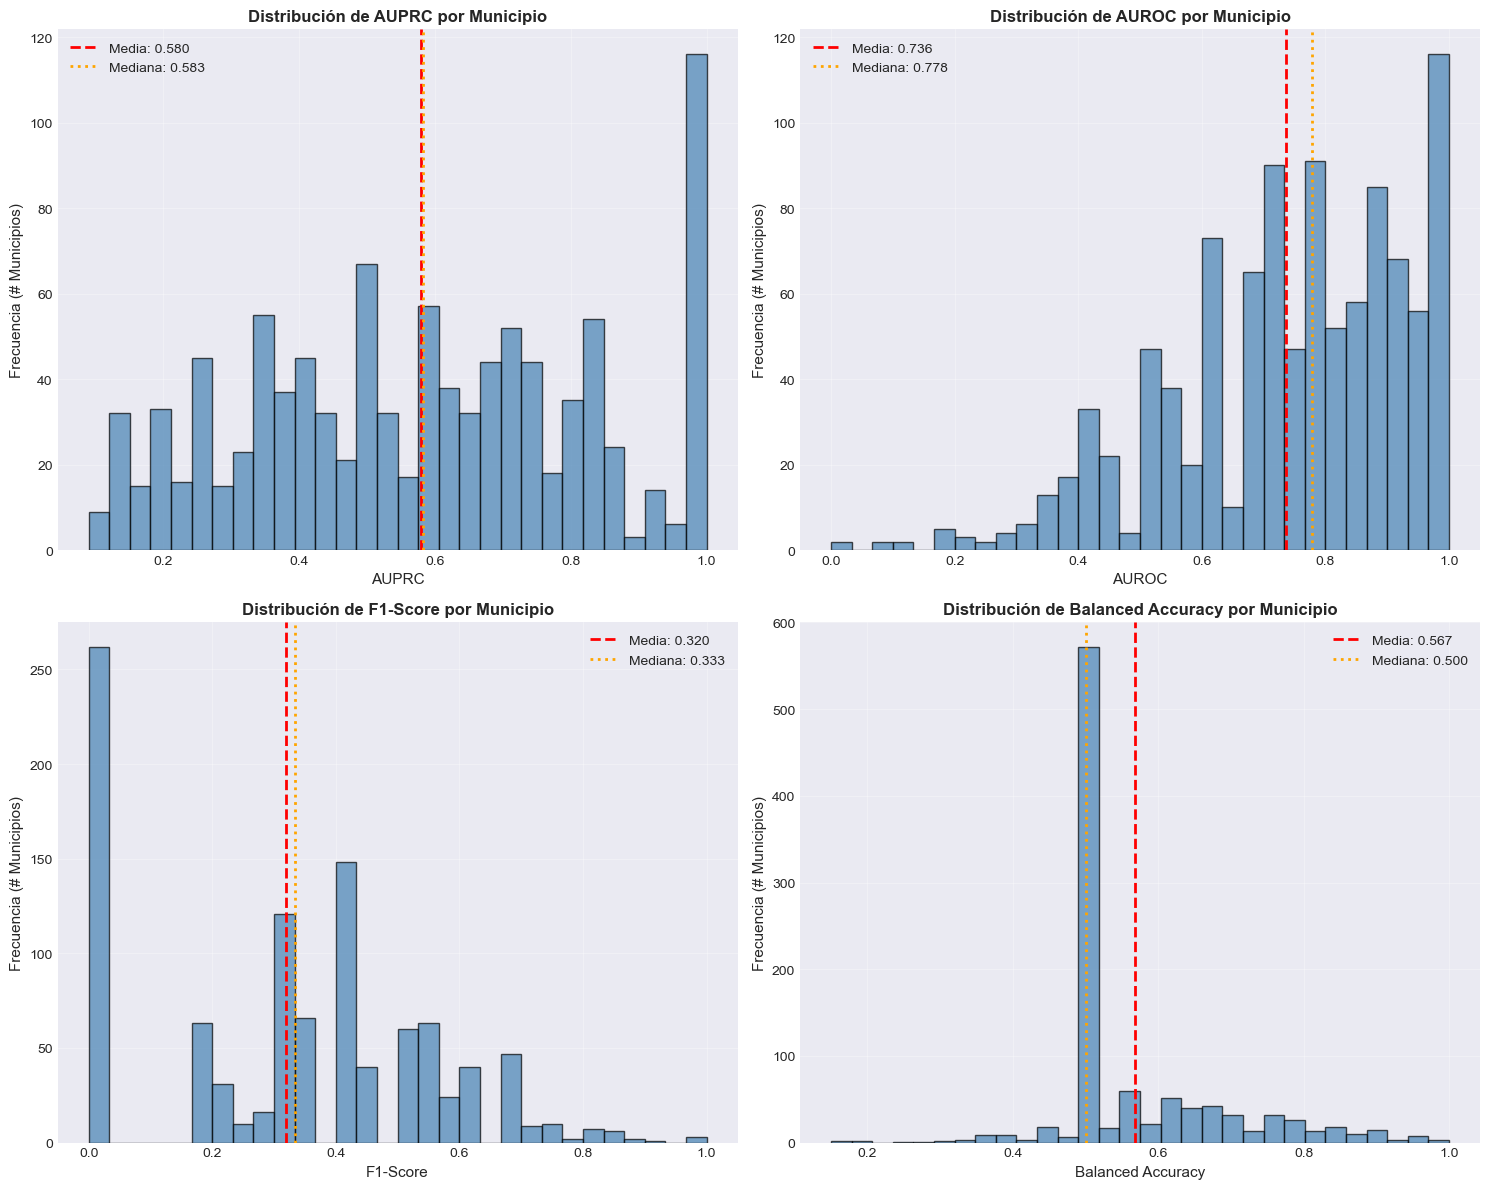

In [12]:
# Visualizar distribución de performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics_to_plot = ['auprc', 'auroc', 'f1', 'balanced_acc']
titles = ['AUPRC', 'AUROC', 'F1-Score', 'Balanced Accuracy']

for ax, metric, title in zip(axes.flat, metrics_to_plot, titles):
    values = mun_performance_valid[metric].dropna()
    
    # Histogram
    ax.hist(values, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax.axvline(values.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Media: {values.mean():.3f}')
    ax.axvline(values.median(), color='orange', linestyle=':', linewidth=2,
               label=f'Mediana: {values.median():.3f}')
    
    ax.set_xlabel(title, fontsize=11)
    ax.set_ylabel('Frecuencia (# Municipios)', fontsize=11)
    ax.set_title(f'Distribución de {title} por Municipio', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Identificar municipios con mejor y peor performance
n_top = 20

# Top performers (AUPRC)
top_performers = mun_performance_valid.nlargest(n_top, 'auprc')[[
    'mun_code', 'auprc', 'auroc', 'f1', 'n_obs', 'prevalence'
]].copy()

# Bottom performers (AUPRC)
bottom_performers = mun_performance_valid.nsmallest(n_top, 'auprc')[[
    'mun_code', 'auprc', 'auroc', 'f1', 'n_obs', 'prevalence'
]].copy()

print(f"\n{'='*70}")
print(f"TOP {n_top} MUNICIPIOS - MEJOR PERFORMANCE")
print(f"{'='*70}\n")
print(top_performers.to_string(index=False))

print(f"\n{'='*70}")
print(f"BOTTOM {n_top} MUNICIPIOS - PEOR PERFORMANCE")
print(f"{'='*70}\n")
print(bottom_performers.to_string(index=False))


TOP 20 MUNICIPIOS - MEJOR PERFORMANCE

mun_code  auprc  auroc       f1  n_obs  prevalence
   05031    1.0    1.0 0.200000     11    0.090909
   05059    1.0    1.0 0.888889     11    0.454545
   05091    1.0    1.0 0.000000     11    0.272727
   05101    1.0    1.0 0.000000     11    0.272727
   05129    1.0    1.0 0.307692     11    0.181818
   05134    1.0    1.0 0.307692     11    0.181818
   05206    1.0    1.0 0.400000     11    0.363636
   05240    1.0    1.0 0.444444     11    0.181818
   05264    1.0    1.0 0.307692     11    0.181818
   05380    1.0    1.0 0.307692     11    0.181818
   05495    1.0    1.0 0.222222     11    0.090909
   05501    1.0    1.0 0.000000     11    0.090909
   05642    1.0    1.0 0.666667     11    0.181818
   05659    1.0    1.0 0.166667     11    0.090909
   05664    1.0    1.0 0.000000     11    0.272727
   05789    1.0    1.0 0.222222     11    0.090909
   08141    1.0    1.0 0.333333     11    0.090909
   08421    1.0    1.0 0.000000     11    

## 6. Caracterización de Municipios por Performance

In [14]:
# Mergear con características de municipios
# Obtener características promedio por municipio del dataset original
mun_characteristics = df.groupby(MUNICIPALITY_COL).agg({
    'iacv_r1': 'mean',
    'iacv_r2': 'mean',
    'IPM_2005': 'first',  # Constante en el tiempo
    'nbi_2005': 'first',
    'women_share': 'mean',
    'discapital': 'first',
    'altura': 'first',
    'indrural': 'first',
    'areaoficialkm2': 'first'
}).reset_index()

mun_characteristics.columns = [
    'mun_code', 'iacv_r1_mean', 'iacv_r2_mean', 'IPM_2005', 'nbi_2005',
    'women_share', 'discapital', 'altura', 'indrural', 'area_km2'
]

# Mergear con performance
mun_analysis = mun_performance_valid.merge(mun_characteristics, on='mun_code', how='left')

print(f"Municipios con características: {len(mun_analysis)}")

Municipios con características: 1031


In [15]:
# Categorizar municipios por performance
mun_analysis['performance_category'] = pd.cut(
    mun_analysis['auprc'],
    bins=[0, 0.4, 0.6, 1.0],
    labels=['Bajo', 'Medio', 'Alto']
)

print("Distribución por categoría de performance:")
print(mun_analysis['performance_category'].value_counts().sort_index())

Distribución por categoría de performance:
performance_category
Bajo     284
Medio    266
Alto     481
Name: count, dtype: int64


In [16]:
# Comparar características entre grupos de performance
comparison = mun_analysis.groupby('performance_category')[[
    'iacv_r1_mean', 'iacv_r2_mean', 'IPM_2005', 'nbi_2005',
    'discapital', 'altura', 'indrural', 'area_km2', 'prevalence'
]].mean()

print("\n" + "="*70)
print("CARACTERÍSTICAS PROMEDIO POR NIVEL DE PERFORMANCE")
print("="*70 + "\n")
print(comparison.round(4))


CARACTERÍSTICAS PROMEDIO POR NIVEL DE PERFORMANCE

                      iacv_r1_mean  iacv_r2_mean  IPM_2005  nbi_2005  \
performance_category                                                   
Bajo                        1.3026        1.3049   68.9328   44.2736   
Medio                       1.5437        1.5492   69.6164   44.5141   
Alto                        1.7128        1.7176   68.3978   44.8038   

                      discapital     altura  indrural  area_km2  prevalence  
performance_category                                                         
Bajo                     80.7874  1172.6866    0.5970   82.1624      0.1597  
Medio                    83.2064  1086.6917    0.5688  125.6234      0.2317  
Alto                     78.6923  1082.6258    0.5635  190.7715      0.2482  


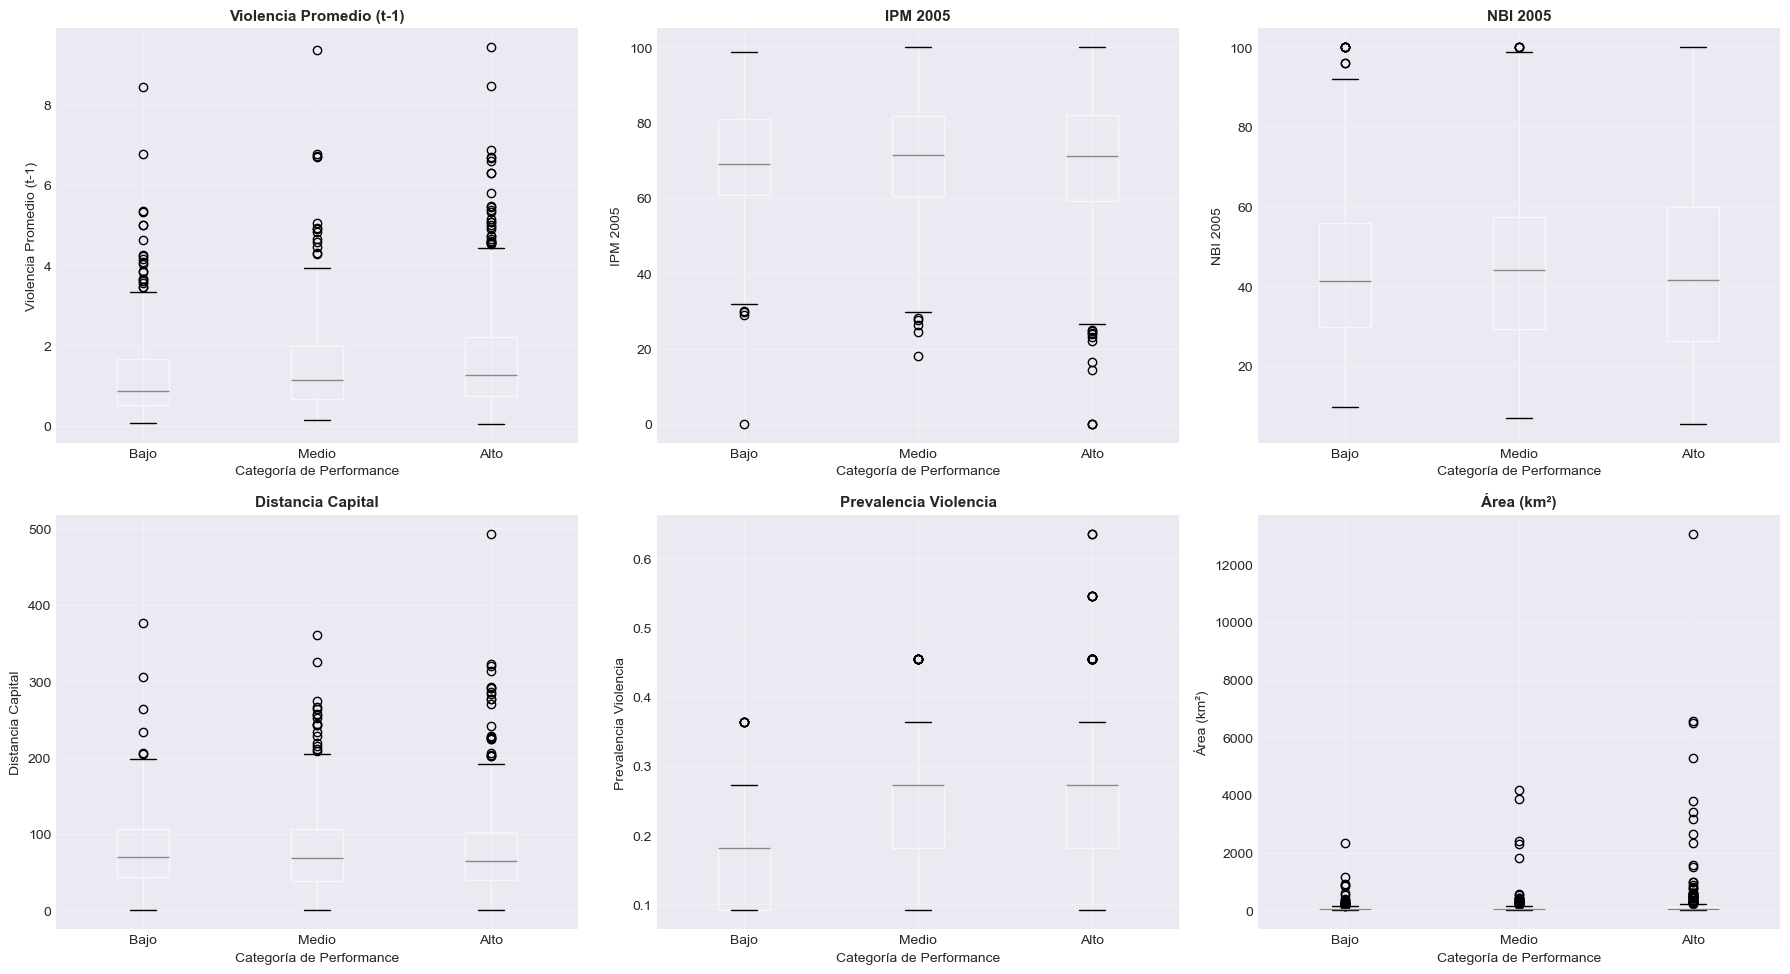

In [17]:
# Visualizar diferencias
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
features_to_compare = ['iacv_r1_mean', 'IPM_2005', 'nbi_2005', 'discapital', 'prevalence', 'area_km2']
titles = ['Violencia Promedio (t-1)', 'IPM 2005', 'NBI 2005', 
          'Distancia Capital', 'Prevalencia Violencia', 'Área (km²)']

for ax, feature, title in zip(axes.flat, features_to_compare, titles):
    # Boxplot por categoría
    mun_analysis.boxplot(column=feature, by='performance_category', ax=ax)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Categoría de Performance', fontsize=10)
    ax.set_ylabel(title, fontsize=10)
    ax.get_figure().suptitle('')  # Remove default title
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Correlaciones entre Características y Performance

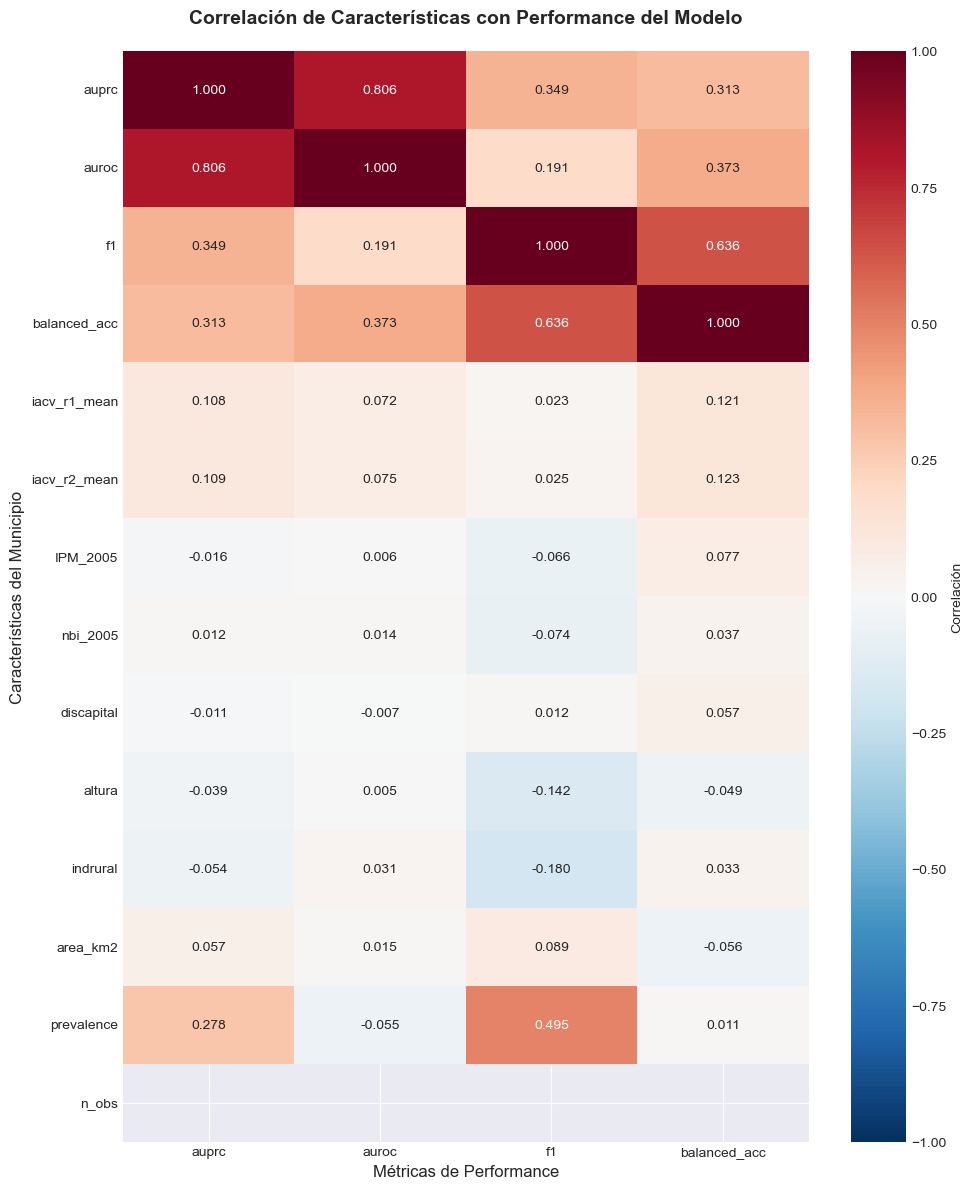


Correlaciones con AUPRC (ordenadas):
prevalence      0.277687
iacv_r2_mean    0.108552
iacv_r1_mean    0.108278
area_km2        0.056605
nbi_2005        0.011557
discapital     -0.010780
IPM_2005       -0.016062
altura         -0.039200
indrural       -0.054299
n_obs                NaN
Name: auprc, dtype: float64


In [18]:
# Calcular correlaciones
correlation_features = [
    'auprc', 'auroc', 'f1', 'balanced_acc',
    'iacv_r1_mean', 'iacv_r2_mean', 'IPM_2005', 'nbi_2005',
    'discapital', 'altura', 'indrural', 'area_km2', 'prevalence', 'n_obs'
]

corr_matrix = mun_analysis[correlation_features].corr()

# Visualizar correlaciones con métricas de performance
performance_metrics = ['auprc', 'auroc', 'f1', 'balanced_acc']
corr_with_performance = corr_matrix.loc[performance_metrics, :].T

plt.figure(figsize=(10, 12))
sns.heatmap(corr_with_performance, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Correlación'})
plt.title('Correlación de Características con Performance del Modelo',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Métricas de Performance', fontsize=12)
plt.ylabel('Características del Municipio', fontsize=12)
plt.tight_layout()
plt.show()

print("\nCorrelaciones con AUPRC (ordenadas):")
print(corr_with_performance['auprc'].drop(['auprc', 'auroc', 'f1', 'balanced_acc']).sort_values(ascending=False))

## 8. Tests Estadísticos de Diferencias

In [19]:
from scipy import stats

# Test de Kruskal-Wallis (no paramétrico) para diferencias entre grupos
print("="*70)
print("TESTS ESTADÍSTICOS - Diferencias entre Categorías de Performance")
print("="*70 + "\n")

test_features = ['iacv_r1_mean', 'IPM_2005', 'nbi_2005', 'discapital', 'prevalence']

for feature in test_features:
    groups = []
    for cat in ['Bajo', 'Medio', 'Alto']:
        data = mun_analysis[mun_analysis['performance_category'] == cat][feature].dropna()
        if len(data) > 0:
            groups.append(data)
    
    if len(groups) >= 2:
        h_stat, p_value = stats.kruskal(*groups)
        print(f"{feature:25s} | H={h_stat:7.3f} | p-value={p_value:.4f} | {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")

print("\n*** p<0.001, ** p<0.01, * p<0.05, ns=no significativo")

TESTS ESTADÍSTICOS - Diferencias entre Categorías de Performance

iacv_r1_mean              | H= 27.292 | p-value=0.0000 | ***
IPM_2005                  | H=  0.528 | p-value=0.7680 | ns
nbi_2005                  | H=  0.193 | p-value=0.9080 | ns
discapital                | H=  1.747 | p-value=0.4175 | ns
prevalence                | H=154.066 | p-value=0.0000 | ***

*** p<0.001, ** p<0.01, * p<0.05, ns=no significativo


## 9. Identificar Clusters de Municipios

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler as SS

# Features para clustering
clustering_features = [
    'iacv_r1_mean', 'IPM_2005', 'nbi_2005', 'discapital', 'prevalence'
]

# Preparar datos
X_cluster = mun_analysis[clustering_features].dropna()
mun_codes_cluster = mun_analysis.loc[X_cluster.index, 'mun_code']

# Estandarizar
scaler_cluster = SS()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# K-Means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_cluster_scaled)

# Agregar cluster al análisis
mun_analysis.loc[X_cluster.index, 'cluster'] = clusters

print("Municipios por cluster:")
print(mun_analysis['cluster'].value_counts().sort_index())

Municipios por cluster:
cluster
0.0    274
1.0    446
2.0    311
Name: count, dtype: int64


In [21]:
# Performance promedio por cluster
cluster_performance = mun_analysis.groupby('cluster')[[
    'auprc', 'auroc', 'f1', 'balanced_acc',
    'iacv_r1_mean', 'IPM_2005', 'discapital', 'prevalence'
]].mean()

print("\n" + "="*70)
print("PERFORMANCE Y CARACTERÍSTICAS POR CLUSTER")
print("="*70 + "\n")
print(cluster_performance.round(4))

# Identificar el "mejor" cluster
best_cluster = cluster_performance['auprc'].idxmax()
print(f"\n✓ Cluster con mejor performance: {best_cluster}")
print(f"  AUPRC promedio: {cluster_performance.loc[best_cluster, 'auprc']:.4f}")


PERFORMANCE Y CARACTERÍSTICAS POR CLUSTER

          auprc   auroc      f1  balanced_acc  iacv_r1_mean  IPM_2005  \
cluster                                                                 
0.0      0.6131  0.7430  0.3343        0.5746        2.3371   84.3602   
1.0      0.5242  0.7302  0.2490        0.5637        1.0442   72.5551   
2.0      0.6315  0.7387  0.4092        0.5662        1.6024   49.9034   

         discapital  prevalence  
cluster                          
0.0        136.7823      0.2422  
1.0         61.2754      0.1675  
2.0         58.2647      0.2742  

✓ Cluster con mejor performance: 2.0
  AUPRC promedio: 0.6315


## 10. Exportar Resultados

In [22]:
import os
from datetime import datetime

os.makedirs(RESULTS_DIR, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Archivo 1: Performance por municipio
perf_file = os.path.join(RESULTS_DIR, f'municipality_performance_{timestamp}.csv')
mun_analysis.to_csv(perf_file, index=False)
print(f"✓ Performance por municipio: {perf_file}")

# Archivo 2: Top y bottom performers
top_file = os.path.join(RESULTS_DIR, f'top_performers_{timestamp}.csv')
top_performers.to_csv(top_file, index=False)
print(f"✓ Top performers: {top_file}")

bottom_file = os.path.join(RESULTS_DIR, f'bottom_performers_{timestamp}.csv')
bottom_performers.to_csv(bottom_file, index=False)
print(f"✓ Bottom performers: {bottom_file}")

# Archivo 3: Estadísticas por cluster
cluster_file = os.path.join(RESULTS_DIR, f'cluster_analysis_{timestamp}.csv')
cluster_performance.to_csv(cluster_file)
print(f"✓ Análisis de clusters: {cluster_file}")

print("\n" + "="*70)
print("ANÁLISIS DE HETEROGENEIDAD POR MUNICIPIO COMPLETADO")
print("="*70)

✓ Performance por municipio: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/municipality_performance_20260201_120559.csv
✓ Top performers: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/top_performers_20260201_120559.csv
✓ Bottom performers: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/bottom_performers_20260201_120559.csv
✓ Análisis de clusters: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/cluster_analysis_20260201_120559.csv

ANÁLISIS DE HETEROGENEIDAD POR MUNICIPIO COMPLETADO


## 11. Resumen Ejecutivo

In [23]:
print("\n" + "#"*70)
print("# RESUMEN EJECUTIVO - HETEROGENEIDAD EN PREDICCIÓN")
print("#"*70 + "\n")

print(f"Municipios analizados: {len(mun_performance_valid)}")
print(f"\nPerformance global (AUPRC):")
print(f"  Media:  {mun_performance_valid['auprc'].mean():.4f}")
print(f"  Rango:  [{mun_performance_valid['auprc'].min():.4f}, {mun_performance_valid['auprc'].max():.4f}]")
print(f"  Std:    {mun_performance_valid['auprc'].std():.4f}")

# Variabilidad
cv = mun_performance_valid['auprc'].std() / mun_performance_valid['auprc'].mean()
print(f"\nCoeficiente de variación: {cv:.2f}")

if cv > 0.3:
    print("\n🔴 ALTA HETEROGENEIDAD detectada")
    print("   El modelo predice MUY DIFERENTE en distintos municipios")
    print("   Recomendación: Considerar modelos segmentados por tipo de municipio")
elif cv > 0.15:
    print("\n🟡 HETEROGENEIDAD MODERADA detectada")
    print("   Performance varía significativamente entre municipios")
    print("   Recomendación: Analizar características de municipios bien/mal predichos")
else:
    print("\n🟢 HETEROGENEIDAD BAJA")
    print("   Performance relativamente consistente entre municipios")

# Características distintivas
print("\n" + "-"*70)
print("CARACTERÍSTICAS DE MUNICIPIOS BIEN PREDICHOS:")
print("-"*70)

high_perf = mun_analysis[mun_analysis['performance_category'] == 'Alto']
if len(high_perf) > 0:
    print(f"  N = {len(high_perf)}")
    print(f"  AUPRC promedio: {high_perf['auprc'].mean():.4f}")
    print(f"  Violencia promedio: {high_perf['iacv_r1_mean'].mean():.4f}")
    print(f"  IPM promedio: {high_perf['IPM_2005'].mean():.4f}")
    print(f"  Prevalencia violencia: {high_perf['prevalence'].mean():.2%}")

print("\n" + "-"*70)
print("CARACTERÍSTICAS DE MUNICIPIOS MAL PREDICHOS:")
print("-"*70)

low_perf = mun_analysis[mun_analysis['performance_category'] == 'Bajo']
if len(low_perf) > 0:
    print(f"  N = {len(low_perf)}")
    print(f"  AUPRC promedio: {low_perf['auprc'].mean():.4f}")
    print(f"  Violencia promedio: {low_perf['iacv_r1_mean'].mean():.4f}")
    print(f"  IPM promedio: {low_perf['IPM_2005'].mean():.4f}")
    print(f"  Prevalencia violencia: {low_perf['prevalence'].mean():.2%}")

print("\n" + "#"*70)


######################################################################
# RESUMEN EJECUTIVO - HETEROGENEIDAD EN PREDICCIÓN
######################################################################

Municipios analizados: 1031

Performance global (AUPRC):
  Media:  0.5802
  Rango:  [0.0909, 1.0000]
  Std:    0.2535

Coeficiente de variación: 0.44

🔴 ALTA HETEROGENEIDAD detectada
   El modelo predice MUY DIFERENTE en distintos municipios
   Recomendación: Considerar modelos segmentados por tipo de municipio

----------------------------------------------------------------------
CARACTERÍSTICAS DE MUNICIPIOS BIEN PREDICHOS:
----------------------------------------------------------------------
  N = 481
  AUPRC promedio: 0.8083
  Violencia promedio: 1.7128
  IPM promedio: 68.3978
  Prevalencia violencia: 24.82%

----------------------------------------------------------------------
CARACTERÍSTICAS DE MUNICIPIOS MAL PREDICHOS:
------------------------------------------------------------------